In [1]:
import numpy as np
from numpy.linalg import norm
import ipywidgets as widgets
rng = np.random.default_rng(12345)
import matplotlib.pyplot as plt
import time 
import seaborn as sns
sns.set_theme()

from Pedestrian import Pedestrian
from Environment import Environment

## Construct some environments

In [2]:
bar_end1 = [np.array([75,50]),np.array([20,25])] 
bar_end2 = [np.array([15,80]), np.array([10,25])] 
obstacles = [bar_end1, bar_end2]

wagons = Environment(obstacles, "Wagons")

bar_end1 = [np.array([20,15]),np.array([25,70])] 
bar_end2 = [np.array([10,15]),np.array([15,70])]
bar_end3 = [np.array([25,70]),np.array([150,70])] 
bar_end4 = [np.array([15,70]),np.array([-100,70])] 
bar_end5 = [np.array([150,150]),np.array([150,70])] 
bar_end6 = [np.array([-100,150]),np.array([-100,70])] 

obstacles = [bar_end1, bar_end2, bar_end3, bar_end4,bar_end5, bar_end6]
corridor = Environment(obstacles, "Corridor")


#Corridor
height, width, left, right, wagon = 55, 10, 20, 60, 50
bar_end1 = [np.array([left,height]),np.array([right,height])]
bar_end2 = [np.array([left,height-width]),np.array([right,height-width])]
bar_end3 = [np.array([right,height]),np.array([right+wagon,height+wagon])]
bar_end4 = [np.array([right,height-width]),np.array([right+wagon,height-width-wagon])]
bar_end5 = [np.array([left,height]),np.array([left-wagon,height+wagon])]
bar_end6 = [np.array([left,height-width]),np.array([left-wagon,height-width-wagon])]

obstacles = [bar_end1, bar_end2, bar_end3, bar_end4,bar_end5, bar_end6]
corridor_two_way = Environment(obstacles, "Corridor two way")

"""
wagons.plot()
corridor.plot()
corridor_two_way.plot() 
""";

## Wagon queue

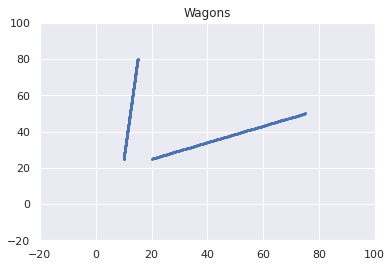

In [26]:
wagons.plot()

In [13]:
steps = int(1000/8)
n_agents = 40
pedestrians_wagons = []
targets = rng.uniform(-30,0,2*n_agents).reshape(2,n_agents)
positions = rng.uniform(80,100,2*n_agents).reshape(2,n_agents)
for agent in range(n_agents):
    pedestrians_wagons.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=wagons.obstacles))

t0 = time.time()
for step in range(steps):
    for ped in pedestrians_wagons: # Assess sourrounding pedestrians (obstacles are automatically assesed)
        ped.assess_players(list(filter(lambda x: x != ped, pedestrians_wagons)))
    for ped in pedestrians_wagons: # Perform optimal step
        ped.walk_theta()
print("Runtime:", round(time.time() - t0,2))

Runtime: 21.16


In [14]:
obstacles_plot = wagons.obstacles_to_plot()

drag = 10
size = 2
@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for ped in pedestrians_wagons:
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    for ped in pedestrians_wagons:
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}")

interactive(children=(IntSlider(value=2, description='n', max=125, min=2, step=5), Output()), _dom_classes=('w…

## Corridor with one directional flow

In [ ]:
corridor.plot()

In [ ]:
steps = int(1000/2)
n_agents = 30
pedestrians_corridor = []
targets = rng.uniform(-30,0,2*n_agents).reshape(2,n_agents)
positions = rng.uniform(80,100,2*n_agents).reshape(2,n_agents)
for agent in range(n_agents):
    pedestrians_corridor.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=corridor.obstacles))

t0 = time.time()
for step in range(steps):
    for ped in pedestrians_corridor: # Assess sourrounding pedestrians (obstacles are automatically assesed)
        ped.assess_players(list(filter(lambda x: x != ped, pedestrians_corridor)))
    for ped in pedestrians_corridor: # Perform optimal step
        ped.walk_theta()
print("Runtime:", round(time.time() - t0,2))

In [ ]:
obstacles_plot = corridor.obstacles_to_plot()

drag = 1
size = 2
@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for ped in pedestrians_corridor:
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    for ped in pedestrians_corridor:
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}")

## Corridor with two directional flow

In [ ]:
corridor_two_way.plot()

In [3]:
steps = int(1000/8)
n_agents = 100
n_agents_left, n_agents_right = int(n_agents/2), int(n_agents/2)
pedestrians_corridor_two_way = []
targets_left = rng.uniform(-30,0,2*n_agents_left).reshape(2,n_agents_left)
targets_left[1,:] = 3*20 + targets_left[1,:]
targets_right =  rng.uniform(80,100,2*n_agents_right).reshape(2,n_agents_right)
targets_right[1,:] = -2*20 + targets_right[1,:]
targets = np.concatenate([targets_left,targets_right],axis=1)
positions_left =  rng.uniform(80,100,2*n_agents_left).reshape(2,n_agents_left)
positions_left[1,:] = -2*20 + positions_left[1,:]
positions_right = rng.uniform(-30,0,2*n_agents_right).reshape(2,n_agents_right)
positions_right[1,:] = 3*20 + positions_right[1,:]
positions = np.concatenate([positions_left,positions_right],axis=1)
for agent in range(n_agents):
    pedestrians_corridor_two_way.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=corridor_two_way.obstacles))

t0 = time.time()
for step in range(steps):
    # II Asses position of sororunding pedestrians (obstacles are automatically assesed)
    for ped in pedestrians_corridor_two_way: 
        ped.assess_players(list(filter(lambda x: x != ped, pedestrians_corridor_two_way)))
    # I Fix preferred direction
    # III Choose optimal step
    for ped in pedestrians_corridor_two_way:
        ped.walk_theta()
print("Runtime:", round(time.time() - t0,2))

Runtime: 221.19


In [4]:
obstacles_plot = corridor_two_way.obstacles_to_plot()

drag = 10
size = .2
@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"{corridor_two_way.name}:Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i <= n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}", color=color)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i <= n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}", color=color)

interactive(children=(IntSlider(value=2, description='n', max=125, min=2, step=5), Output()), _dom_classes=('w…

In [5]:
# Flow plot
obstacles_plot = corridor_two_way.obstacles_to_plot()

drag = steps
size = .1
@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"{corridor_two_way.name}:Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i <= n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.plot(ped.target[0],ped.target[1], alpha=size, label=f"{ped}", color=color)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i <= n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.plot(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], alpha=size, label=f"{ped}", color=color)

interactive(children=(IntSlider(value=2, description='n', max=125, min=2, step=5), Output()), _dom_classes=('w…